In [1]:
import os.path
import re

import pandas as pd
import numpy as np

from scipy.cluster.vq import kmeans, kmeans2
from sklearn.cluster import KMeans

import seaborn as sns

Load the data and pre-process it.

In [2]:
FILEPATH = os.path.abspath("../data/2023-03-25_22hr_29min_ptwr_data.tsv")
df = pd.read_csv(FILEPATH, sep="\t")

MAKE = "make"
MODEL = "model"
SPECS = "specs"

CLEAN_MAKE = re.compile(r"((/make/)|(\-power\-to\-weight\-ratio\-stats))")
CLEAN_MODEL = re.compile(r"(/model/)")
CLEAN_SPECS = re.compile(r"(\\t|\\n)")

df[MAKE] = df[MAKE].apply(lambda x: CLEAN_MAKE.sub("", x))
df[MODEL] = df[MODEL].apply(lambda x: CLEAN_MODEL.sub("", x))
df[SPECS] = df[SPECS].apply(lambda x: CLEAN_SPECS.sub("", x))

SEPARATOR = ":"
SPECS1 = "specs1"
df[SPECS1] = df[SPECS].apply(lambda x: float(x.split(SEPARATOR)[-1]))
df[SPECS] = df[SPECS].apply(lambda x: SEPARATOR.join((x.split(SEPARATOR)[:-1])))

print(df.describe())
print(df.head())

             specs1
count  43219.000000
mean       0.064918
std        0.029648
min        0.017000
25%        0.050000
50%        0.059000
75%        0.070000
max        0.636000
    make     model                      specs  specs1
0  acura  acura-cl         1997 Acura CL 2.2    0.047
1  acura  acura-cl         1998 Acura CL 2.3    0.049
2  acura  acura-cl  1998 Acura CL 2.3 Premium   0.049
3  acura  acura-cl         1999 Acura CL 2.3    0.049
4  acura  acura-cl         1997 Acura CL 3.0    0.062


# Introduction

I am going to explore some models for this data. I will use discriminators for classifying high power-to-weight or low power-to-weight based upon mean, median and some clustering algorithms. I will first explore the discriminants and then start analysing classification models based upon each of those techniques.

# !Methodology!

I want to impose labels upon this unsupervised data and find an unsupervised classification technique which can perform adequately given the goals of this analysis. Validation is done here by training an unsupervised classification technique on subsets of the data set and predicting the rest of the data set. These classifications are compared to the results of training the unsupervised classification technique upon the entire data set and then predicting that entire data set. In the absence of objective ground truth labels, this classification of the whole stands in. As such, the accuracies calculated here are more relative accuracies than objective accuracies, relative to having all of the information versus subsets of it. The goal is to identify an unsupervised classification technique for this data set that performs as well with a subset of data as it would if you had all of the data. The goal is to find the best performing classification technique, starting with a more general case and building up to the more specific case in objective 3 -- a process of elimination.

# Attempt 1: Mean

Create a discriminant based upon being above or below the mean.

In [3]:
mean = np.mean(df[SPECS1])
print(mean)

0.06491797589023347


# Attemp 2: Median

Create a discriminant based upon being above or below the median.

In [4]:
median = np.median(df[SPECS1])
print(median)

0.059


# Attempt 3: Clustering

## K-Means Clustering

Clustering with k=2 because we want 'high power to weight ratio' vs 'low power to weight ratio', just those two.
Create a discriminant based upon which centroid a datum is closer to.

In [5]:
K = 2

### Scipy kmeans

In [6]:
kmeans_centroids, distortion = kmeans(df[SPECS1], K)
print(kmeans_centroids)

[0.0549868  0.10406804]


### Scipy kmeans2

In [7]:
kmeans2_centroids, distortion2 = kmeans2(df[SPECS1], K)
print(kmeans2_centroids)

[0.13564123 0.05848388]


### Sklearn KMeans

In [8]:
X = df[SPECS1].to_numpy().reshape(-1,1)
cf = KMeans(n_clusters=K, n_init='auto').fit(X)
sklearn_centroids = cf.cluster_centers_
print(sklearn_centroids)

[[0.05891207]
 [0.14092449]]


# Discussion: Attempts 1-3

I don't think there is a lot of preprocessing to be done here, but now that I have some models I can start to classify the data and compare the results. A classification of '1' means 'high power-to-weight ratio' and a classification of '0' means 'low power-to-weight ratio'. An assumption here is that inferring the training data produces the ground truth labels.

### Constants

In [9]:
HIGH = 1
LOW = 0

NUM_FOLDS = 7
LENGTH = len(df)
NUM_ITERATIONS = 200

# df = df.sample(frac=1)

# Attempt 1 Classification: Mean Discriminator

In [10]:
def mean_inference(df, mean):
    result = df.apply(lambda x: HIGH if x > mean else LOW)
    return result

<Axes: xlabel='Accuracy', ylabel='Std'>

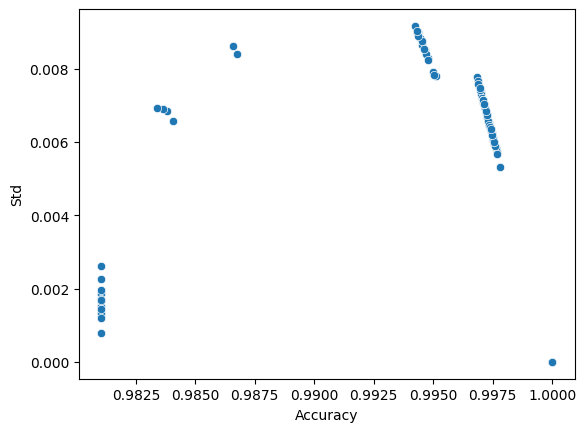

In [13]:
metrics_overall = []
for _ in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    mean_reference = mean_inference(df[SPECS1], mean)

    metrics = {}
    for i in range(NUM_FOLDS):
        test = df.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
        train_values = df[~df.index.isin(test.index)][SPECS1]

        mean = np.mean(train_values)
        test_inferred = mean_inference(test[SPECS1], mean)
        mean_reference_test_view = mean_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

        # positive class is HIGH
        tp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == HIGH])
        tn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x == y and x == LOW])
        fp = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == HIGH])
        fn = np.sum([True for x,y in zip(test_inferred,mean_reference_test_view) if x != y and x == LOW])

        metrics[str(i)] = [tp, tn, fp, fn]
    metrics_overall.append(metrics)

metric_data_for_plot = []
for metrics in metrics_overall:
    accuracies = []
    for key, val in metrics.items():
        accuracies.append((val[0]+val[1])/np.sum(val))
    mean_accuracy_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Attempt 2 Classification: Median Discriminator

In [12]:
def median_inference(df, median):
    result = df.apply(lambda x: HIGH if x > median else LOW)
    return result

<Axes: xlabel='Accuracy', ylabel='Std'>

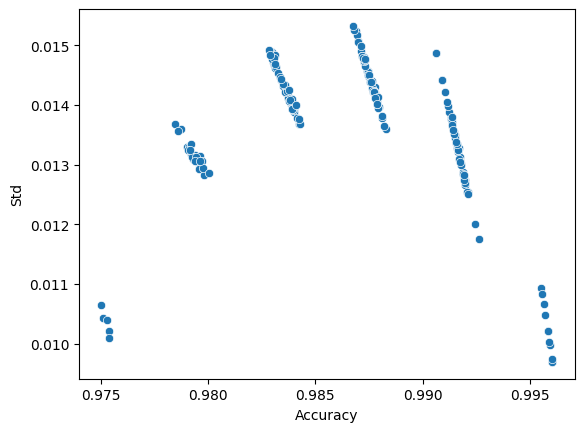

In [14]:
metrics_overall = []
for _ in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    median_reference = mean_inference(df[SPECS1], median)

    metrics = {}
    for i in range(NUM_FOLDS):
        test = df.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
        train_values = df[~df.index.isin(test.index)][SPECS1]

        median = np.median(train_values)
        test_inferred = mean_inference(test[SPECS1], median)
        median_reference_test_view = median_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

        # positive class is HIGH
        tp = np.sum([True for x,y in zip(test_inferred,median_reference_test_view) if x == y and x == HIGH])
        tn = np.sum([True for x,y in zip(test_inferred,median_reference_test_view) if x == y and x == LOW])
        fp = np.sum([True for x,y in zip(test_inferred,median_reference_test_view) if x != y and x == HIGH])
        fn = np.sum([True for x,y in zip(test_inferred,median_reference_test_view) if x != y and x == LOW])

        metrics[str(i)] = [tp, tn, fp, fn]
    metrics_overall.append(metrics)

metric_data_for_plot = []
for metrics in metrics_overall:
    accuracies = []
    for key, val in metrics.items():
        accuracies.append((val[0]+val[1])/np.sum(val))
    mean_accuracy_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Attempt 3 Classification: K-Means Clustering Discriminator

In [15]:
def kmeans_inference(df, high_centroid, low_centroid):
    result = df.apply(lambda x: HIGH if np.abs(high_centroid-x) < np.abs(low_centroid-x) else LOW)
    return result

### Scipy kmeans

<Axes: xlabel='Accuracy', ylabel='Std'>

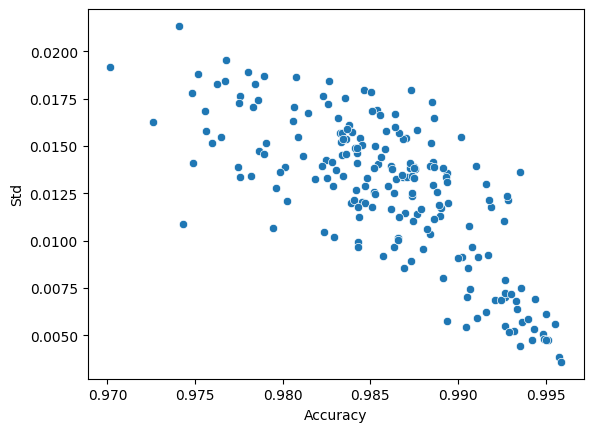

In [18]:
metrics_overall = []
for _ in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    high_kmeans_centroid = kmeans_centroids[1] if kmeans_centroids[1] > kmeans_centroids[0] else kmeans_centroids[0]
    low_kmeans_centroid = kmeans_centroids[1] if kmeans_centroids[1] < kmeans_centroids[0] else kmeans_centroids[0]
    kmeans_reference = kmeans_inference(df[SPECS1], high_kmeans_centroid, low_kmeans_centroid)

    metrics = {}
    for i in range(NUM_FOLDS):
        test = df.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
        train_values = df[~df.index.isin(test.index)][SPECS1]

        centroids, distortion = kmeans(train_values, K)
        high_centroid = centroids[1] if centroids[1] > centroids[0] else centroids[0]
        low_centroid = centroids[1] if centroids[1] < centroids[0] else centroids[0]
        test_inferred = kmeans_inference(test[SPECS1], high_centroid, low_centroid)
        kmeans_reference_test_view = kmeans_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

        # positive class is HIGH
        tp = np.sum([True for x,y in zip(test_inferred,kmeans_reference_test_view) if x == y and x == HIGH])
        tn = np.sum([True for x,y in zip(test_inferred,kmeans_reference_test_view) if x == y and x == LOW])
        fp = np.sum([True for x,y in zip(test_inferred,kmeans_reference_test_view) if x != y and x == HIGH])
        fn = np.sum([True for x,y in zip(test_inferred,kmeans_reference_test_view) if x != y and x == LOW])

        metrics[str(i)] = [tp, tn, fp, fn]
    metrics_overall.append(metrics)

metric_data_for_plot = []
for metrics in metrics_overall:
    accuracies = []
    for key, val in metrics.items():
        accuracies.append((val[0]+val[1])/np.sum(val))
    mean_accuracy_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

### Scipy kmeans2

/Users/alexanderdeforge/Documents/projects/repos/vehicles-power-to-weight/.venv/lib/python3.9/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


<Axes: xlabel='Accuracy', ylabel='Std'>

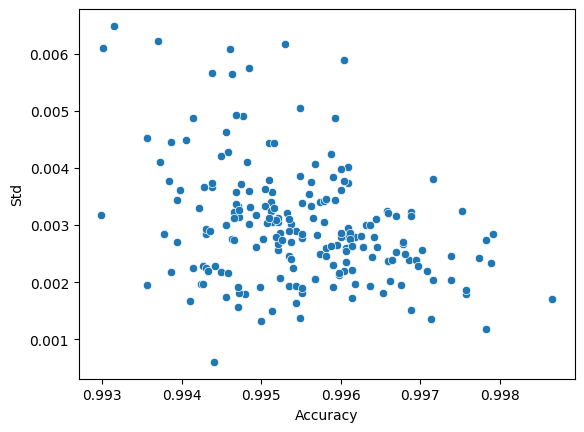

In [19]:
metrics_overall = []
for _ in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    high_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] > kmeans2_centroids[0] else kmeans2_centroids[0]
    low_kmeans2_centroid = kmeans2_centroids[1] if kmeans2_centroids[1] < kmeans2_centroids[0] else kmeans2_centroids[0]
    kmeans2_reference = kmeans_inference(df[SPECS1], high_kmeans2_centroid, low_kmeans2_centroid)

    metrics = {}
    for i in range(NUM_FOLDS):
        test = df.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
        train_values = df[~df.index.isin(test.index)][SPECS1]

        centroids, distortion = kmeans2(train_values, K)
        high_centroid = centroids[1] if centroids[1] > centroids[0] else centroids[0]
        low_centroid = centroids[1] if centroids[1] < centroids[0] else centroids[0]
        test_inferred = kmeans_inference(test[SPECS1], high_centroid, low_centroid)
        kmeans2_reference_test_view = kmeans2_reference.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

        # positive class is HIGH
        tp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == HIGH])
        tn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x == y and x == LOW])
        fp = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == HIGH])
        fn = np.sum([True for x,y in zip(test_inferred,kmeans2_reference_test_view) if x != y and x == LOW])

        metrics[str(i)] = [tp, tn, fp, fn]
    metrics_overall.append(metrics)

metric_data_for_plot = []
for metrics in metrics_overall:
    accuracies = []
    for key, val in metrics.items():
        accuracies.append((val[0]+val[1])/np.sum(val))
    mean_accuracy_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

### Sklearn KMeans

<Axes: xlabel='Accuracy', ylabel='Std'>

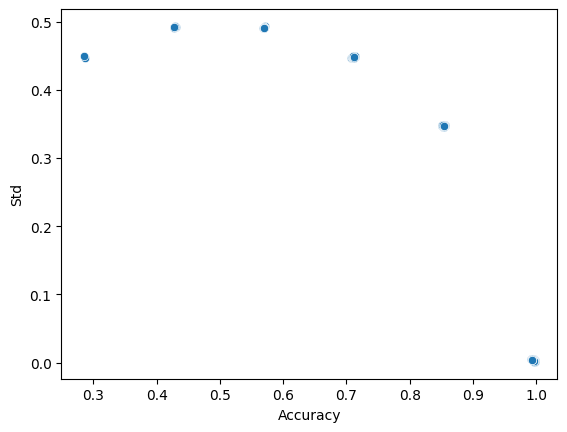

In [21]:
metrics_overall = []
for _ in range(NUM_ITERATIONS):
    df = df.sample(frac=1)
    sklearn_reference = cf.predict(df[SPECS1].to_numpy().reshape(-1,1))

    metrics = {}
    for i in range(NUM_FOLDS):
        test = df.iloc[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]
        train_values = df[~df.index.isin(test.index)][SPECS1]

        train_values = train_values.to_numpy().reshape(-1,1)
        sklearn_cf = KMeans(n_clusters=K, n_init='auto').fit(train_values)
        test_inferred = sklearn_cf.predict(test[SPECS1].to_numpy().reshape(-1,1))
        sklearn_reference_test_view = sklearn_reference[int(np.floor(LENGTH/NUM_FOLDS)*i):int(np.floor(LENGTH/NUM_FOLDS)*(i+1))]

        # positive class is HIGH
        tp = np.sum([True for x,y in zip(test_inferred,sklearn_reference_test_view) if x == y and x == HIGH])
        tn = np.sum([True for x,y in zip(test_inferred,sklearn_reference_test_view) if x == y and x == LOW])
        fp = np.sum([True for x,y in zip(test_inferred,sklearn_reference_test_view) if x != y and x == HIGH])
        fn = np.sum([True for x,y in zip(test_inferred,sklearn_reference_test_view) if x != y and x == LOW])

        metrics[str(i)] = [tp, tn, fp, fn]
    metrics_overall.append(metrics)

metric_data_for_plot = []
for metrics in metrics_overall:
    accuracies = []
    for key, val in metrics.items():
        accuracies.append((val[0]+val[1])/np.sum(val))
    mean_accuracy_overall = np.mean(accuracies)
    mean_std_overall = np.std(accuracies)
    metric_data_for_plot.append((mean_accuracy_overall,mean_std_overall))
df_plot = pd.DataFrame(metric_data_for_plot, columns=["Accuracy", "Std"])

sns.scatterplot(df_plot, x="Accuracy", y="Std")

# Discussion: Classification Attempts 1-3

With a 70/30 train/test split for k-fold cross validation and averaging the accuracies, I would argue that the mean or kmeans2 discriminators work best because of the low standard deviations along with the high accuracies. They had some of the lowest standard deviations as well as high accuracies which implies they may generalize well. I chose accuracy as the fitness metric because of the general nature of the problem. We want to maximize correct classifications and don't need to dig deeper into precision or recall, etc, which tends to be dictated by the application. Again, this application is fairly straightforward, classify the power-to-weight ratios as either 'high' or 'low' and we want to get that right as much as possible -- no further details.

# Answer for Objective 1

For this data, a high power-to-weight ratio is either anything above the mean and a low power-to-weight ratio is anything below the mean, such that the mean is 0.0649.
Or, a high power-to-weight ratio is closer to the value 0.13564123 than the value 0.05848388, and vice-versa for a low power-to-weight ratio.

Next I will explore these top techniques on the data partitioned by model year in order to further narrow down the best algorithm to use for this data.